Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2107 - val_loss: 0.0481
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0738 - val_loss: 0.0457
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0619 - val_loss: 0.0450
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0567 - val_loss: 0.0471
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0552 - val_loss: 0.0446
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0552 - val_loss: 0.0453
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0547 - val_loss: 0.0449
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0533 - val_loss: 0.0447
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0532 - val_loss: 0.0457
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0573 - val_loss: 0.0447
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0527 - val_loss: 0.0446
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0517 - val_loss: 0.0454

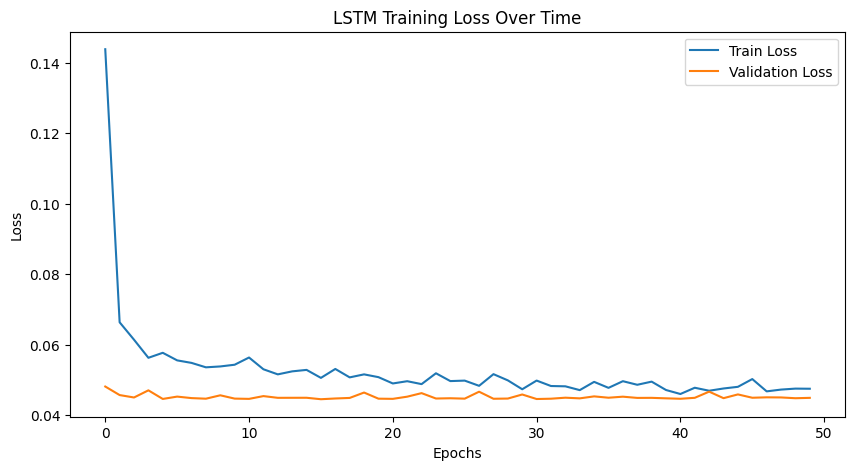

    Actual  Predicted
0      7.0   6.376946
1     21.0  13.767264
2     22.0  21.037422
3     30.0  29.273888
4     35.0  35.851891
5     39.0  42.721195
6      6.0   7.169507
7     30.0  15.000200
8     34.0  21.671570
9     45.0  28.420202
10    46.0  35.488422
11    48.0  43.119785
12     3.0   6.648838
13     6.0  13.884985
14     8.0  20.554600
15    11.0  27.573740
16    36.0  34.450466
17    48.0  42.115952
18     2.0   7.436672
19    11.0  15.179490
20    23.0  22.043978
21    24.0  28.355198
22    33.0  35.543850
23    44.0  43.163166
24     1.0   6.690759
25     4.0  14.165378
26     6.0  20.847055
27    15.0  28.096455
28    40.0  34.989845
29    44.0  42.502441


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Dataset
df = pd.read_csv('./toto_cleaned_file.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# Extract useful date-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Week'] = df['Date'].dt.weekday  # Monday=0, Thursday=3

# Select relevant columns (winning numbers only)
winning_cols = [f'Winning Number {i}' for i in range(1, 7)]
data = df[winning_cols].copy()

# Normalize the data (LSTMs work better with scaled data)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences for LSTM (we predict next set based on last 10 draws)
def create_sequences(data, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(data_scaled, sequence_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(6, activation='linear')  # Predicting 6 winning numbers
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict next draw
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)  # Convert back to original scale

# Evaluate model
mse = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse}')

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training Loss Over Time')
plt.legend()
plt.show()

# Show a few predictions vs actual values
comparison = pd.DataFrame({'Actual': scaler.inverse_transform(y_test)[:5].flatten(),
                           'Predicted': y_pred_rescaled[:5].flatten()})
print(comparison)
